In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

Using TensorFlow backend.


# IMDB 감정분석

In [2]:
max_features = 10000
max_len = 500

print("data load...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), "train sequence")
print(len(x_test), "test sequence")

print("sequence padding (samples x tiem)")
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print("size of x_train : ", x_train.shape)
print("size of x_test  : ", x_test.shape)

data load...
25000 train sequence
25000 test sequence
sequence padding (samples x tiem)
size of x_train :  (25000, 500)
size of x_test  :  (25000, 500)


In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [4]:
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 147s - loss: 0.7699 - acc: 0.5305 - val_loss: 0.6820 - val_acc: 0.5996
Epoch 2/10
20000/20000 [==============================] - 142s - loss: 0.6629 - acc: 0.6775 - val_loss: 0.6571 - val_acc: 0.6662
Epoch 3/10
20000/20000 [==============================] - 142s - loss: 0.6119 - acc: 0.7609 - val_loss: 0.5939 - val_acc: 0.7192
Epoch 4/10
20000/20000 [==============================] - 142s - loss: 0.5125 - acc: 0.8138 - val_loss: 0.4899 - val_acc: 0.7834
Epoch 5/10
20000/20000 [==============================] - 146s - loss: 0.4073 - acc: 0.8478 - val_loss: 0.4102 - val_acc: 0.8318
Epoch 6/10
20000/20000 [==============================] - 142s - loss: 0.3441 - acc: 0.8651 - val_loss: 0.3892 - val_acc: 0.8462
Epoch 7/10
20000/20000 [==============================] - 142s - loss: 0.3060 - acc: 0.8696 - val_loss: 0.3924 - val_acc: 0.8298
Epoch 8/10
20000/20000 [========================

In [6]:
import matplotlib.pyplot as plt

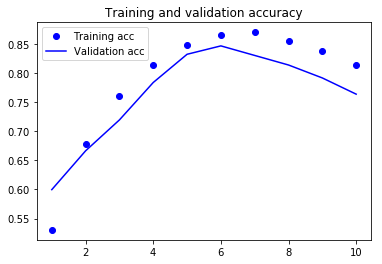

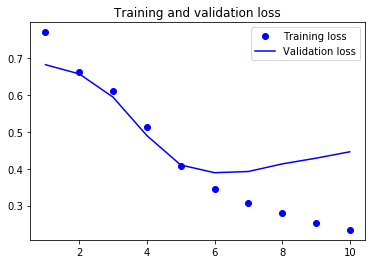

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 온도분석

In [8]:
import os
import numpy as np

data_dir = './datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [9]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

In [10]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 75s - loss: 0.4113 - val_loss: 0.4330s: 0.411
Epoch 2/20
500/500 [==============================] - 75s - loss: 0.3590 - val_loss: 0.4410
Epoch 3/20
500/500 [==============================] - 75s - loss: 0.3358 - val_loss: 0.4497
Epoch 4/20
500/500 [==============================] - 75s - loss: 0.3219 - val_loss: 0.4553 ETA: 0s - loss: 0.
Epoch 5/20
500/500 [==============================] - 75s - loss: 0.3110 - val_loss: 0.4694
Epoch 6/20
500/500 [==============================] - 75s - loss: 0.3037 - val_loss: 0.4971
Epoch 7/20
500/500 [==============================] - 75s - loss: 0.2955 - val_loss: 0.4727
Epoch 8/20
500/500 [==============================] - 75s - loss: 0.2902 - val_loss: 0.4672
Epoch 9/20
500/500 [==============================] - 75s - loss: 0.2836 - val_loss: 0.5020 0s - loss
Epoch 10/20
500/500 [==============================] - 75s - loss: 0.2766 - val_loss: 0.4890
Epoch 11/20
500/500 [=====================

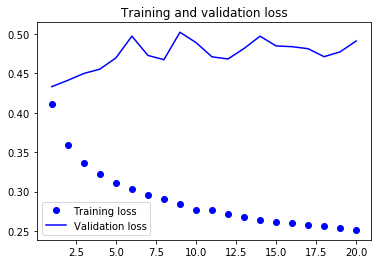

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

컨브넷의 속도와 경량함을 RNN의 순서 감지 능력과 결합하는 한가지 전략은 1D 컨브넷을 RNN 이전에 전처리 단계로 사용하는 것입니다. 수천 개의 스텝을 가진 시퀀스 같이 RNN으로 처리하기엔 현실적으로 너무 긴 시퀀스를 다룰 때 특별히 도움이 됩니다. 컨브넷이 긴 입력 시퀀스를 더 짧은 고수준 특성의 (다운 샘플된) 시퀀스로 변환합니다. 추출된 특성의 시퀀스는 RNN 파트의 입력이 됩니다.

이 기법이 연구 논문이나 실전 애플리케이션에 자주 등장하지는 않습니다. 아마도 널리 알려지지 않았기 때문일 것입니다. 이 방법은 효과적이므로 많이 사용되기를 바랍니다. 온도 예측 문제에 적용해 보죠. 이 전략은 훨씬 긴 시퀀스를 다룰 수 있으므로 더 오래전 데이터를 바라보거나(데이터 제너레이터의 lookback 매개변수를 증가시킵니다), 시계열 데이터를 더 촘촘히 바라볼 수 있습니다(제너레이터의 step 매개변수를 감소시킵니다). 여기서는 그냥 step을 절반으로 줄여서 사용하겠습니다. 온도 데이터가 30분마다 1 포인트씩 샘플링되기 때문에 결과 시계열 데이터는 두 배로 길어집니다. 앞서 정의한 제너레이터 함수를 다시 사용합니다.

In [12]:
step = 3
lookback = 1440
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [13]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPool1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 333s - loss: 0.3376 - val_loss: 0.3025
Epoch 2/20
500/500 [==============================] - 333s - loss: 0.3033 - val_loss: 0.2893
Epoch 3/20
500/500 [==============================] - 333s - loss: 0.2913 - val_loss: 0.2796
Epoch 4/20
500/500 [==============================] - 333s - loss: 0.2826 - val_loss: 0.2738
Epoch 5/20
500/500 [==============================] - 333s - loss: 0.2753 - val_loss: 0.2824
Epoch 6/20
500/500 [==============================] - 334s - loss: 0.2688 - val_loss: 0.2789
Epoch 7/20
500/500 [==============================] - 333s - loss: 0.2645 - val_loss: 0.2740
Epoch 8/20
500/500 [==============================] - 333s - loss: 0.2589 - val_loss: 0.2727
Epoch 9/20
500/500 [==============================] - 333s - loss: 0.2539 - val_loss: 0.2835
Epoch 10/20
500/500 [==============================] - 334s - loss: 0.2510 - val_loss: 0.2782
Epoch 11/20
500/500 [==============================] - 333s - loss: 0

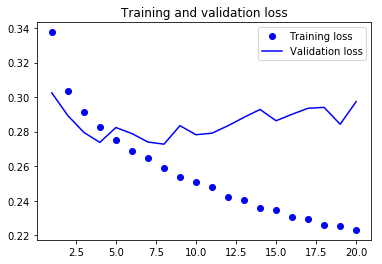

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()